In [1]:
import pandas as pd
import numpy as np
# Plot histograms for sentiment_score and Close price
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from collections import Counter
import re
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
import gensim
from gensim import corpora

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
filepath_numerical = '/content/drive/My Drive/nlp/dataset_final/finsen_s&p500/S&P500_numerical.csv'
filepath_sentiment = '/content/drive/My Drive/nlp/dataset_final/finsen_s&p500/FinSen_text_annotated.csv'

In [6]:
data_num = pd.read_csv(filepath_numerical)
data_num.head()

,Price,Open,Close,High,Volume
0,Ticker,^GSPC,^GSPC,^GSPC,^GSPC
1,Date,NaN,NaN,NaN,NaN
2,2023-07-14,4514.6,4505.41,4527.75,3647450000.0
3,2023-07-13,4491.5,4510.04,4517.37,3839530000.0
4,2023-07-12,4467.68,4472.16,4488.33,3920290000.0


In [7]:
data_sent = pd.read_csv(filepath_sentiment)
data_sent.head()

,Unnamed: 0,Title,Tag,Time,Content,sentiment_score
0,0,"TSX Slightly Down, Books Weekly Gains",Stock Market,16/07/2023,"TSX Slightly Down, Books Weekly GainsUnited St...",0.13
1,1,UnitedHealth Hits 4-week High,stocks,15/07/2023,UnitedHealth Hits 4-week HighUnited States sto...,0.62
2,2,Cisco Systems Hits 4-week Low,stocks,15/07/2023,Cisco Systems Hits 4-week LowUnited States sto...,-0.43
3,3,AT&T Hits All-time Low,stocks,15/07/2023,AT&T Hits All-time LowUnited States stocksAT&T...,-0.28
4,4,Microsoft Hits 4-week High,stocks,15/07/2023,Microsoft Hits 4-week HighUnited States stocks...,0.60


In [8]:
if 'Unnamed: 0' in data_sent.columns:
    data_sent = data_sent.drop(columns=['Unnamed: 0'])
data_sent.rename(columns={'Time': 'Date'}, inplace=True)
data_sent.head()

,Title,Tag,Date,Content,sentiment_score
0,"TSX Slightly Down, Books Weekly Gains",Stock Market,16/07/2023,"TSX Slightly Down, Books Weekly GainsUnited St...",0.13
1,UnitedHealth Hits 4-week High,stocks,15/07/2023,UnitedHealth Hits 4-week HighUnited States sto...,0.62
2,Cisco Systems Hits 4-week Low,stocks,15/07/2023,Cisco Systems Hits 4-week LowUnited States sto...,-0.43
3,AT&T Hits All-time Low,stocks,15/07/2023,AT&T Hits All-time LowUnited States stocksAT&T...,-0.28
4,Microsoft Hits 4-week High,stocks,15/07/2023,Microsoft Hits 4-week HighUnited States stocks...,0.60


In [10]:
data_sent.value_counts()

,,,,,count
Title,Tag,Date,Content,sentiment_score,
US Core PPI Rises Less than Expected,Core Producer Prices MoM,14/07/2023,"US Core PPI Rises Less than ExpectedUnited States Core Producer Prices MoMCore producer prices in the United States increased by 0.1% over a month in June 2023, matching May's revised reading and slightly below market estimates of a 0.2% rise. On a yearly basis, core consumer prices advanced by 2.4% in June, slowing from a downwardly revised 2.6% increase in May and below market expectations of a 2.6% rise.",0.00,2
Dollar Languishes on Dovish Fed Bets,Currency,15/07/2023,"Dollar Languishes on Dovish Fed BetsUnited States CurrencyThe dollar index held its recent decline to below 100 on Friday, sinking to its lowest levels in 15 months as signs that US inflation is on a downward trend raised hopes that the Federal Reserve is nearing the end of its current monetary policy tightening cycle. Latest data showed that US consumer and producer inflation rose less than anticipated in June even as the US labor market remained robust. The US central bank is still seen raising rates by 25 basis points in July, while traders scaled back bets of further rate increases after this year. Market pricing also suggests that the Fed could start cutting rates next year. The dollar plunged to over one-year lows against the euro and sterling, while it declined to multi-month lows against the yen and antipodean currencies.",-0.27,2
Progressive earnings below expectations at 0.57 USD,Earnings,14/07/2023,"Progressive earnings below expectations at 0.57 USDUnited States EarningsProgressive (PGR) released earnings per share at 0.57 USD, compared to market expectations of 0.89 USD.",0.01,2
US Budget Deficit Widens More than Expected in June,Government Budget Value,14/07/2023,"US Budget Deficit Widens More than Expected in JuneUnited States Government Budget ValueThe US government budget deficit came at USD 227.8 billion in June 2023, widening from a USD 88.8 billion gap in the same month of the previous year, and below market expectations of a USD 175 billion deficit as revenues continued to weaken and July benefit payments were accelerated into June. Revenues declined by 9.2% to USD 418 billion due to lower non-withheld individual income taxes. Outlays soared 17.5% to $646 billion led by higher individual tax refunds as the Internal Revenue Service cleared a backlog of unprocessed receipts. Considering the first nine months of the fiscal year, the budget deficit stood at USD 1.393 trillion compared to a USD 1.375 billion deficit a year earlier.",-0.06,2
PepsiCo earnings above expectations at 2.09 USD,Earnings,14/07/2023,"PepsiCo earnings above expectations at 2.09 USDUnited States EarningsPepsiCo (PEP) released earnings per share at 2.09 USD, compared to market expectations of 1.96 USD.",0.01,2
...,...,...,...,...,...
Philadelphia Factory Activity Unexpectedly Grows,Philadelphia Fed Manufacturing Index,17/03/2022,"Philadelphia Factory Activity Unexpectedly GrowsUnited States Philadelphia Fed Manufacturing IndexThe Philadelphia Fed Manufacturing Index in the US rose to 27.4 in March of 2022 from 16 in February and above market expectations of 15. It was the highest reading since last November. The survey’s indicators for general activity, shipments, and new orders all rose after declining last month. The employment index and both price indexes climbed higher and remain elevated. The survey’s future general activity, new orders, and shipments indexes moderated, but the surveyed firms remained generally optimistic about growth over the next six months.",0.32,1
Philadelphia Factory Growth Eases for 2nd Month,Philadelphia Fed Manufacturing Index,17/06/2021,"Philadelphia Factory Growth Eases for 2nd MonthUnited States Philadelphia Fed Manufacturing IndexThe Philadelphia Fed Manufacturing Index in the US fell for the second month to 30.7 in June of 2021 from 31.5 in May, compared to market forecasts of 31. Still, the reading showed manufact

In [11]:
data_sent = data_sent.drop_duplicates(subset=['Title', 'Content'])
data_sent.value_counts()

,,,,,count
Title,Tag,Date,Content,sentiment_score,
10-Year Treasury Note Approaches 3-Month Low After CPI,Government Bond 10Y,13/12/2022,"10-Year Treasury Note Approaches 3-Month Low After CPIUnited States Government Bond 10YThe yield on the US 10-year Treasury noted retreated below the 3.5% mark, approaching the three-month low of 3.4% touched on December 7th after the domestic inflation report surprised to the downside, easing expectations of how high the Federal Reserve will have to raise its funds rate target. Consumer prices rose by 7.1% annually in November, below estimates of 7.3% and easing from 7.7% in the prior month. The result consolidated hopes of slowing price growth as data showed that consumer inflation expectations dropped to the lowest in 14 months, adding to bets that the Federal Reserve will deliver a 50bps rate hike this week and maintain smaller rate hike increments after four straight 75bps increases since June.",-0.01,1
US Industrial Output Rises The Most In 3 Years,Industrial Production Mom,16/05/2017,"US Industrial Output Rises The Most In 3 YearsUnited States Industrial Production MomUS industrial production increased by 1 percent month-over-month in April 2017, following a downwardly revised 0.4 percent rise in March and beating market expectations of a 0.3 percent gain. It was the largest increase in industrial production since February 2014, as output rebounded for both manufacturing and mining while utilities grew at a slower pace.",0.23,1
US Industrial Production Growth Hits 5-Month High,Industrial Production,18/10/2022,"US Industrial Production Growth Hits 5-Month HighUnited States Industrial ProductionIndustrial production in the United States increased 5.3 percent year-on-year in September 2022, the most since April, accelerating from an upwardly revised 3.9 percent advance in the previous month. Manufacturing output growth accelerated to 4.7 percent from 3.5 percent in August, due to a 6.0 percent jump in the production of durable manufacturing, led by motor vehicles and parts, fabricated metal products, machinery, and aerospace and miscellaneous transportation equipment. Also, nondurable manufacturing increased 3.6 percent, boosted by the production of food, beverage, and tobacco products, and chemicals. Mining output jumped 11.1 percent (8.7 percent), while utilities output moved up 0.5 percent as a 4.3 percent advance in natural gas production was partially offset by a 0.3 percent decline in electric output. On a monthly basis, industrial output rose 0.4 percent in September, beating market forecasts of 0.1 percent.",0.50,1
US Industrial Production Growth Strongest in 8-Months,Industrial Production Mom,14/08/2015,US Industrial Production Growth Strongest in 8-MonthsUnited States Industrial Production MomIndustrial output in the US rose 0.6 percent in July after a downwardly revised increase of 0.1 percent in June. The gain was a result of a 0.8 percent growth in factory production supported by a surge in production of motor vehicles.,0.22,1
US Industrial Production Rebounds,Industrial Production Mom,15/07/2015,"US Industrial Production ReboundsUnited States Industrial Production MomIndustrial output rose 0.3 percent in June from May, beating market expectations and recovering from contraction in the previous two months. It is the highest gain in seven months boosted by mining and utilities while manufacturing was flat.",0.46,1
...,...,...,...,...,...
Philadelphia Fed Manufacturing Index At 2-Year High,Philadelphia Fed Manufacturing Index,15/12/2016,"Philadelphia Fed Manufacturing Index At 2-Year High United States Philadelphia Fed Manufacturing IndexThe Philadelphia Fed Manufacturing Index surged to 21.5 in December of 2016 from 7.6 in November and well above market expectations of 9. It was the highest reading since November 2014. The shipments increased to 22 (from 19.5) and employment rebounded (6.4 from -2.6). Meantime, new orders index went down to 13.9 (from 18.6) and inventories de

***Merge DataFrames***

In [12]:
# Aggregate sentiment scores by summing them up for each date
data_sent_aggregated = (
    data_sent.groupby('Date', as_index=False)
    .agg({'sentiment_score': 'sum'})
)

# Round the sentiment_score to two decimal places
data_sent_aggregated['sentiment_score'] = data_sent_aggregated['sentiment_score'].round(2)

# Merge aggregated scores back into the original DataFrame
data_sent = data_sent.drop(columns=['sentiment_score'])  # Drop original sentiment_score column
data_sent = data_sent.merge(data_sent_aggregated, on='Date', how='left')  # Add aggregated column

print(data_sent)


                                                   Title               Tag  \
0                  TSX Slightly Down, Books Weekly Gains      Stock Market   
1                          UnitedHealth Hits 4-week High            stocks   
2                          Cisco Systems Hits 4-week Low            stocks   
3                                 AT&T Hits All-time Low            stocks   
4                             Microsoft Hits 4-week High            stocks   
...                                                  ...               ...   
15478  United States GDP Rises 0.6 percent in the fir...   GDP Growth Rate   
15479  Consumer Price Index 2.6 percent higher than i...    Inflation Rate   
15480  U.S. Federal Reserve Kept Rates Unchanged at 5...     Interest Rate   
15481              Trade Deficit Increases in March 2007  Balance of Trade   
15482  Blackstone boosts IPO after Beijing takes $3bn...              News   

             Date                                            Co

In [14]:
print("--- data_num ---")
print(data_num.head())
print(data_num.columns)

print("\n--- data_sent ---")
print(data_sent.head())
print(data_sent.columns)

--- data_num ---
        Price     Open    Close     High        Volume
0      Ticker    ^GSPC    ^GSPC    ^GSPC         ^GSPC
1        Date      NaN      NaN      NaN           NaN
2  2023-07-14   4514.6  4505.41  4527.75  3647450000.0
3  2023-07-13   4491.5  4510.04  4517.37  3839530000.0
4  2023-07-12  4467.68  4472.16  4488.33  3920290000.0
Index(['Price', 'Open', 'Close', 'High', 'Volume'], dtype='object')

--- data_sent ---
                                   Title           Tag        Date  \
0  TSX Slightly Down, Books Weekly Gains  Stock Market  16/07/2023   
1          UnitedHealth Hits 4-week High        stocks  15/07/2023   
2          Cisco Systems Hits 4-week Low        stocks  15/07/2023   
3                 AT&T Hits All-time Low        stocks  15/07/2023   
4             Microsoft Hits 4-week High        stocks  15/07/2023   

                                             Content  sentiment_score  
0  TSX Slightly Down, Books Weekly GainsUnited St...             0.13  
1

In [15]:
import pandas as pd

# --- Step 1: Clean the data_num DataFrame ---

# Remove the first two bad rows (index 0 and 1)
# We use .copy() to avoid a SettingWithCopyWarning
data_num_cleaned = data_num.iloc[2:].copy()

# Rename the 'Price' column to 'Date' since it contains the dates
data_num_cleaned.rename(columns={'Price': 'Date'}, inplace=True)


# --- Step 2: Convert Date columns to datetime format ---

# Convert the new 'Date' column in the cleaned dataframe
data_num_cleaned['Date'] = pd.to_datetime(data_num_cleaned['Date'])

# Convert the 'Date' column in data_sent.
# Use dayfirst=True because your format is DD/MM/YYYY
data_sent['Date'] = pd.to_datetime(data_sent['Date'], dayfirst=True)


# --- Step 3: Merge the cleaned dataframes ---

# Merge on the 'Date' column
data_merged = pd.merge(data_num_cleaned, data_sent, on='Date', how='inner')

# --- Step 4: Verify the result ---
print("Merge successful! Here is the head of the merged data:")
print(data_merged.head())

Merge successful! Here is the head of the merged data:
        Date    Open    Close     High        Volume  \
0 2023-07-14  4514.6  4505.41  4527.75  3647450000.0   
1 2023-07-14  4514.6  4505.41  4527.75  3647450000.0   
2 2023-07-14  4514.6  4505.41  4527.75  3647450000.0   
3 2023-07-14  4514.6  4505.41  4527.75  3647450000.0   
4 2023-07-14  4514.6  4505.41  4527.75  3647450000.0   

                                               Title                      Tag  \
0  US Budget Deficit Widens More than Expected in...  Government Budget Value   
1                             Visa Hits 24-week High                   stocks   
2                           Amazon Hits 43-week High                   stocks   
3       10-Year Treasury Yield Falls for 4th Session      Government Bond 10Y   
4                                 DXY Approaches 100                 Currency   

                                             Content  sentiment_score  
0  US Budget Deficit Widens More than Expected in

In [16]:
data_merged.head()

,Date,Open,Close,High,Volume,Title,Tag,Content,sentiment_score
0,2023-07-14,4514.6,4505.41,4527.75,3647450000.0,US Budget Deficit Widens More than Expected in...,Government Budget Value,US Budget Deficit Widens More than Expected in...,1.02
1,2023-07-14,4514.6,4505.41,4527.75,3647450000.0,Visa Hits 24-week High,stocks,Visa Hits 24-week HighUnited States stocksVisa...,1.02
2,2023-07-14,4514.6,4505.41,4527.75,3647450000.0,Amazon Hits 43-week High,stocks,Amazon Hits 43-week HighUnited States stocksAm...,1.02
3,2023-07-14,4514.6,4505.41,4527.75,3647450000.0,10-Year Treasury Yield Falls for 4th Session,Government Bond 10Y,10-Year Treasury Yield Falls for 4th SessionUn...,1.02
4,2023-07-14,4514.6,4505.41,4527.75,3647450000.0,DXY Approaches 100,Currency,DXY Approaches 100United States CurrencyThe do...,1.02


In [22]:

# Ensure filtered_data is a full copy of data_merged
filtered_data = data_merged.copy()

# Merge all rows for the same date into one row
merged_data = filtered_data.groupby('Date', as_index=False).agg({
    'Open': 'first',
    'Close': 'first',
    'High': 'first',
    'Volume': 'sum',  # Summing volumes for the same date
    'Title': lambda x: ', '.join(x),  # Joining titles with commas
    'Tag': lambda x: ', '.join(x),  # Joining tags with commas
    'Content': lambda x: ', '.join(x),  # Joining content with commas
    'sentiment_score': 'first'  # Assuming sentiment score is already aggregated
})

# Display or save the result
merged_data.head(10)


,Date,Open,Close,High,Volume,Title,Tag,Content,sentiment_score
0,2007-06-04,1536.28,1539.18,1540.53,2738930000.02738930000.0,"Trade Deficit Increases in March 2007, Blackst...","Balance of Trade, News",Trade Deficit Increases in March 2007United St...,0.03
1,2007-06-06,1530.56,1517.38,1530.56,2964190000.02964190000.02964190000.02964190000...,"Nonfarm payroll employment increased by 157,00...","Unemployment Rate, Balance of Trade, GDP Growt...","Nonfarm payroll employment increased by 157,00...",0.01
2,2007-06-21,1512.5,1522.18,1522.9,3161110000.0,US Economy is expanding after Q1 slowdown,GDP Growth Rate,US Economy is expanding after Q1 slowdownUnite...,0.03
3,2007-06-26,1497.68,1492.89,1506.11,3398530000.0,Consumer Confidence and Housing Weaken in US,GDP Growth Rate,Consumer Confidence and Housing Weaken in USUn...,-0.66
4,2007-06-28,1506.31,1505.7,1514.83,3006710000.0,Fed keeps the federal funds rate at 5-1/4 percent,Interest Rate,Fed keeps the federal funds rate at 5-1/4 perc...,0.16
5,2007-07-05,1524.85,1525.4,1526.56,2622950000.0,U.S. ISM Services Index Reached 14-Month High ...,News,U.S. ISM Services Index Reached 14-Month High ...,0.66
6,2007-07-06,1524.95,1530.43,1532.4,2441520000.0,US June unemployment rate unchanged at 4.5%,Unemployment Rate,US June unemployment rate unchanged at 4.5%Uni...,-0.02
7,2007-07-10,1531.84,1510.11,1531.84,3244280000.0,"U.S. Growth, Easing Inflation to Follow Fed `S...",Inflation Rate,"U.S. Growth, Easing Inflation to Follow Fed `S...",0.00
8,2007-07-12,1518.73,1547.69,1547.92,3489600000.0,US trade deficit increases to $60.0 billion in...,Balance of Trade,US trade deficit increases to $60.0 billion in...,-0.02
9,2007-07-18,1549.19,1546.17,1549.19,3609220000.0,Fed chief acknowledges credit fears,Stock Market,Fed chief acknowledges credit fearsUnited Stat...,-0.11


In [24]:
# Check datatypes of all columns in merged_data
print("Column Data Types:\n")
print(merged_data.dtypes)


Column Data Types:

Date               datetime64[ns]
Open                       object
Close                      object
High                       object
Volume                     object
Title                      object
Tag                        object
Content                    object
sentiment_score           float64
dtype: object


In [25]:
# Convert numeric-looking columns to numeric
for col in ['Open', 'Close', 'High', 'Volume']:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# Verify after conversion
print("Data types after conversion:\n")
print(merged_data.dtypes)


Data types after conversion:

Date               datetime64[ns]
Open                      float64
Close                     float64
High                      float64
Volume                    float64
Title                      object
Tag                        object
Content                    object
sentiment_score           float64
dtype: object


In [38]:
# Import necessary library
import numpy as np

# 1. Log Returns
# Daily log return (Close to Open)
merged_data['log_return_daily'] = np.log(merged_data['Close'] / merged_data['Open'])

# Overnight log return (Open of tomorrow to Close of today)
merged_data['log_return_overnight'] = np.log(merged_data['Open'].shift(-1) / merged_data['Close'])

# 2. Volatility
# Daily range as a measure of volatility
merged_data['daily_volatility'] = (merged_data['High'] - merged_data['Open']) / merged_data['Open']

# Rolling standard deviation of daily returns (e.g., 7-day rolling window)
merged_data['rolling_volatility_7'] = merged_data['log_return_daily'].rolling(window=7).std()

# 3. Moving Averages
# Moving average of closing prices
merged_data['moving_avg_close_7'] = merged_data['Close'].rolling(window=7).mean()
merged_data['moving_avg_close_14'] = merged_data['Close'].rolling(window=14).mean()

# Moving average of sentiment scores
merged_data['moving_avg_sentiment_7'] = merged_data['sentiment_score'].rolling(window=7).mean()
merged_data['moving_avg_sentiment_14'] = merged_data['sentiment_score'].rolling(window=14).mean()

# 4. Rolling Sentiment
# Rolling mean and standard deviation of sentiment scores
merged_data['rolling_sentiment_mean_7'] = merged_data['sentiment_score'].rolling(window=7).mean()
merged_data['rolling_sentiment_std_7'] = merged_data['sentiment_score'].rolling(window=7).std()

# 5. Lagged Sentiment
# Lag sentiment by 1 day
merged_data['sentiment_lag_1'] = merged_data['sentiment_score'].shift(1)
# Lag sentiment by 2 days
merged_data['sentiment_lag_2'] = merged_data['sentiment_score'].shift(2)

# 6. Interaction Features
# Interaction between sentiment and daily volatility
merged_data['sentiment_volatility_interaction'] = merged_data['sentiment_score'] * merged_data['daily_volatility']

# Drop NaNs created by rolling or shifting
merged_data = merged_data.dropna()

merged_data.head()


,Date,Open,Close,High,Volume,Title,Tag,Content,sentiment_score,log_return_daily,...,moving_avg_close_14,moving_avg_sentiment_7,moving_avg_sentiment_14,rolling_sentiment_mean_7,rolling_sentiment_std_7,sentiment_lag_1,sentiment_lag_2,sentiment_volatility_interaction,intraday_return,overnight_return
26,2008-02-20,1348.39,1360.03,1363.70,3.870520e+09,Rising Inflation Underlines Challenge to Fed,Inflation Rate,Rising Inflation Underlines Challenge to FedUn...,-0.08,0.008595,...,1417.236429,-0.168571,-0.203571,-0.168571,0.180225,-0.44,-0.30,-0.000908,0.008633,-0.005353
27,2008-02-25,1352.75,1371.80,1374.35,3.866350e+09,Dollar Gains vs Yen,Currency,Dollar Gains vs YenUnited States CurrencyThe d...,0.05,0.013984,...,1408.907143,-0.121429,-0.199286,-0.121429,0.189159,-0.08,-0.44,0.000798,0.014082,-0.005642
28,2008-02-29,1364.06,1330.63,1364.06,4.426730e+09,U.S. Stocks Decline on Economic Concern,Stock Market,U.S. Stocks Decline on Economic ConcernUnited ...,-0.64,-0.024813,...,1399.099286,-0.220000,-0.242143,-0.220000,0.253706,0.05,-0.08,-0.000000,-0.024508,-0.002217
29,2008-03-05,1327.68,1333.69,1344.18,4.277710e+09,Oil Rises Above $104,Commodity,Oil Rises Above $104United States CommodityCru...,-0.01,0.004516,...,1390.577143,-0.200000,-0.221429,-0.200000,0.265393,-0.64,0.05,-0.000124,0.004527,-0.021317
30,2008-03-13,1305.26,1315.47,1321.68,5.073360e+09,Dollar Climbs From Record Low,Currency,Dollar Climbs From Record LowUnited States Cur...,0.00,0.007792,...,1378.507143,-0.202857,-0.212857,-0.202857,0.262724,-0.01,-0.64,0.000000,0.007822,0.028104


In [39]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 559 entries, 26 to 584
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date                              559 non-null    datetime64[ns]
 1   Open                              559 non-null    float64       
 2   Close                             559 non-null    float64       
 3   High                              559 non-null    float64       
 4   Volume                            559 non-null    float64       
 5   Title                             559 non-null    object        
 6   Tag                               559 non-null    object        
 7   Content                           559 non-null    object        
 8   sentiment_score                   559 non-null    float64       
 9   log_return_daily                  559 non-null    float64       
 10  log_return_overnight              559 non-null    floa

In [40]:
# Compute the correlation matrix for numerical columns
numerical_columns = [ 'sentiment_score', 'intraday_return',
    'overnight_return', 'log_return_daily', 'log_return_overnight',
    'daily_volatility']

''''rolling_volatility_7', 'moving_avg_close_7',
    'moving_avg_close_14', 'moving_avg_sentiment_7', 'moving_avg_sentiment_14',
    'rolling_sentiment_mean_7', 'rolling_sentiment_std_7', 'sentiment_lag_1',
    'sentiment_lag_2', 'sentiment_volatility_interaction' '''

correlation_matrix = merged_data[numerical_columns].corr()

# Save or display the correlation matrix
correlation_matrix.to_csv("correlation_matrix.csv")
print(correlation_matrix)


                      sentiment_score  intraday_return  overnight_return  \
sentiment_score              1.000000         0.053765          0.007169   
intraday_return              0.053765         1.000000         -0.171737   
overnight_return             0.007169        -0.171737          1.000000   
log_return_daily             0.055932         0.999865         -0.170989   
log_return_overnight         0.010244        -0.172859          0.999396   
daily_volatility            -0.057224         0.728904         -0.157305   

                      log_return_daily  log_return_overnight  daily_volatility  
sentiment_score               0.055932              0.010244         -0.057224  
intraday_return               0.999865             -0.172859          0.728904  
overnight_return             -0.170989              0.999396         -0.157305  
log_return_daily              1.000000             -0.172024          0.720614  
log_return_overnight         -0.172024              1.000000  

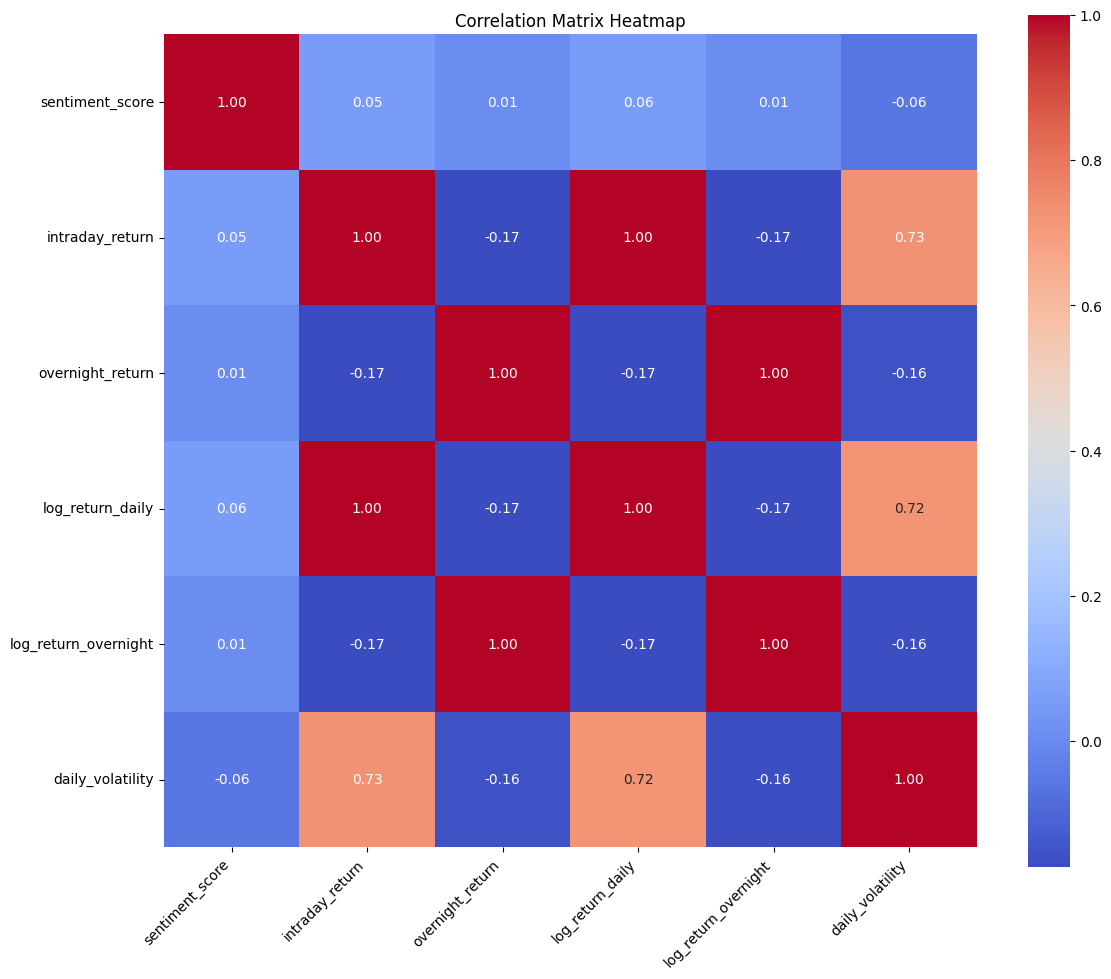

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap for the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Display the plot
plt.show()


In [43]:
from scipy.stats import pearsonr

In [44]:
# Calculate the two types of movements
merged_data['movement_open_close_lag'] = merged_data['Open'] - merged_data['Close'].shift(1)
merged_data['movement_close_close_lag'] = merged_data['Close'] - merged_data['Close'].shift(1)

# Lagged sentiment score (Sentiment on day x-1)
merged_data['sentiment_lag_1'] = merged_data['sentiment_score'].shift(1)

# Drop rows with NaN caused by lagging
valid_data = merged_data.dropna(subset=['sentiment_lag_1', 'movement_open_close_lag', 'movement_close_close_lag'])


# Check if we have enough data points
if len(valid_data) > 1:
    # Correlation between lagged sentiment and Movement 1
    corr_open_close_lag, pval_open_close_lag = pearsonr(
        valid_data['sentiment_lag_1'],
        valid_data['movement_open_close_lag']
    )

    # Correlation between lagged sentiment and Movement 2
    corr_close_close_lag, pval_close_close_lag = pearsonr(
        valid_data['sentiment_lag_1'],
        valid_data['movement_close_close_lag']
    )

    # Print the results
    print(f"Correlation (Lagged Sentiment vs Open-Close Lag Movement): {corr_open_close_lag}, p-value: {pval_open_close_lag}")
    print(f"Correlation (Lagged Sentiment vs Close-Close Lag Movement): {corr_close_close_lag}, p-value: {pval_close_close_lag}")
else:
    print("Not enough data points after dropping NaNs to compute correlations.")


Correlation (Lagged Sentiment vs Open-Close Lag Movement): 0.0033010688712249367, p-value: 0.9379845398672889
Correlation (Lagged Sentiment vs Close-Close Lag Movement): -0.03138196127573102, p-value: 0.45940599600387466


In [45]:
# Compute rolling averages for sentiment score
merged_data['rolling_sentiment_mean_7'] = merged_data['sentiment_score'].rolling(window=7).mean()
merged_data['rolling_sentiment_mean_14'] = merged_data['sentiment_score'].rolling(window=14).mean()

# Compute rolling averages for movements
merged_data['rolling_movement_open_close_7'] = merged_data['movement_open_close_lag'].rolling(window=7).mean()
merged_data['rolling_movement_open_close_14'] = merged_data['movement_open_close_lag'].rolling(window=14).mean()

merged_data['rolling_movement_close_close_7'] = merged_data['movement_close_close_lag'].rolling(window=7).mean()
merged_data['rolling_movement_close_close_14'] = merged_data['movement_close_close_lag'].rolling(window=14).mean()

# Drop rows with NaN caused by rolling calculations
valid_data = merged_data.dropna(subset=[
    'rolling_sentiment_mean_7', 'rolling_sentiment_mean_14',
    'rolling_movement_open_close_7', 'rolling_movement_open_close_14',
    'rolling_movement_close_close_7', 'rolling_movement_close_close_14'
])

# Test correlations for 7-day rolling sentiment
corr_open_close_7, pval_open_close_7 = pearsonr(
    valid_data['rolling_sentiment_mean_7'],
    valid_data['rolling_movement_open_close_7']
)

corr_close_close_7, pval_close_close_7 = pearsonr(
    valid_data['rolling_sentiment_mean_7'],
    valid_data['rolling_movement_close_close_7']
)

# Test correlations for 14-day rolling sentiment
corr_open_close_14, pval_open_close_14 = pearsonr(
    valid_data['rolling_sentiment_mean_14'],
    valid_data['rolling_movement_open_close_14']
)

corr_close_close_14, pval_close_close_14 = pearsonr(
    valid_data['rolling_sentiment_mean_14'],
    valid_data['rolling_movement_close_close_14']
)

# Print results
print(f"7-day Rolling Sentiment vs Rolling Open-Close (7-day): Correlation: {corr_open_close_7}, p-value: {pval_open_close_7}")
print(f"7-day Rolling Sentiment vs Rolling Close-Close (7-day): Correlation: {corr_close_close_7}, p-value: {pval_close_close_7}")

print(f"14-day Rolling Sentiment vs Rolling Open-Close (14-day): Correlation: {corr_open_close_14}, p-value: {pval_open_close_14}")
print(f"14-day Rolling Sentiment vs Rolling Close-Close (14-day): Correlation: {corr_close_close_14}, p-value: {pval_close_close_14}")


7-day Rolling Sentiment vs Rolling Open-Close (7-day): Correlation: 0.21413584695410331, p-value: 4.506278116281523e-07
7-day Rolling Sentiment vs Rolling Close-Close (7-day): Correlation: 0.13313897239043399, p-value: 0.0018400595708092716
14-day Rolling Sentiment vs Rolling Open-Close (14-day): Correlation: 0.32325977695798247, p-value: 1.0102443332028292e-14
14-day Rolling Sentiment vs Rolling Close-Close (14-day): Correlation: 0.2147242980764683, p-value: 4.183275677588077e-07


In [46]:
import numpy as np
from scipy.stats import pearsonr

# 1. Calculate intraday return (Close - Open) / Open
merged_data['intraday_return'] = (merged_data['Close'] - merged_data['Open']) / merged_data['Open']

# Drop rows with NaN in sentiment_score or intraday_return
intraday_df = merged_data[['sentiment_score', 'intraday_return']].dropna()

# Correlate intraday_return with sentiment_score
intraday_corr, intraday_pval = pearsonr(
    intraday_df['sentiment_score'],
    intraday_df['intraday_return']
)

print(f"Correlation between sentiment score and intraday return (Close - Open): {intraday_corr}")
print(f"P-value: {intraday_pval}")

# 2. Calculate overnight return (Open of Tomorrow - Close of Today) / Close of Today
merged_data['overnight_return'] = (merged_data['Open'].shift(-1) - merged_data['Close']) / merged_data['Close']

# Drop rows with NaN in sentiment_score or overnight_return
overnight_df = merged_data[['sentiment_score', 'overnight_return']].dropna()

# Correlate today's sentiment_score with tomorrow's overnight_return
overnight_corr, overnight_pval = pearsonr(
    overnight_df['sentiment_score'],
    overnight_df['overnight_return']
)

print(f"Correlation between today's sentiment score and overnight return (Open of Tomorrow - Close of Today): {overnight_corr}")
print(f"P-value: {overnight_pval}")


Correlation between sentiment score and intraday return (Close - Open): 0.053764544895076975
P-value: 0.2043563466460381
Correlation between today's sentiment score and overnight return (Open of Tomorrow - Close of Today): -0.0005899877334549235
P-value: 0.9889054113338318


***Statistical Summary***

Summary Statistics:
        sentiment_score
count     15210.000000
mean          0.011536
std           1.046219
min          -3.490000
25%          -0.590000
50%          -0.010000
75%           0.590000
max           4.400000


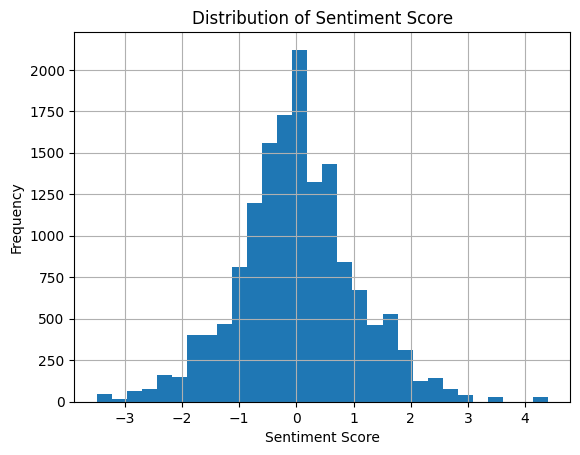

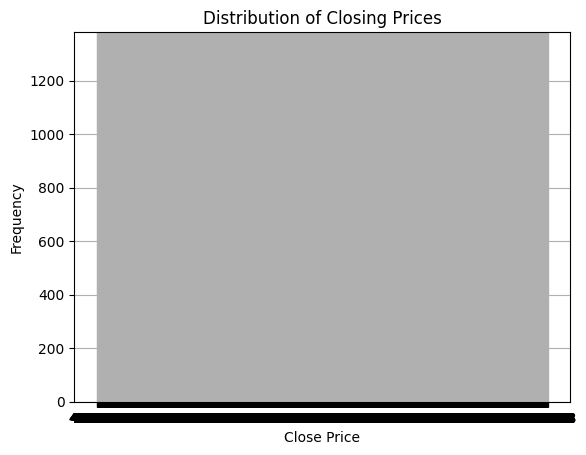

In [48]:
# Basic statistical analysis of numerical features
print("Summary Statistics:\n", data_merged[['sentiment_score', 'Open', 'High', 'Close', 'Volume']].describe())
plt.figure()
data_merged['sentiment_score'].hist(bins=30)
plt.title('Distribution of Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

plt.figure()
data_merged['Close'].hist(bins=30)
plt.title('Distribution of Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()


***Correlation Analysis***

Correlation Matrix:
                  sentiment_score      Open      High     Close    Volume
sentiment_score         1.000000  0.115081  0.117640  0.125435 -0.139060
Open                    0.115081  1.000000  0.999729  0.999287  0.171749
High                    0.117640  0.999729  1.000000  0.999640  0.178662
Close                   0.125435  0.999287  0.999640  1.000000  0.169233
Volume                 -0.139060  0.171749  0.178662  0.169233  1.000000


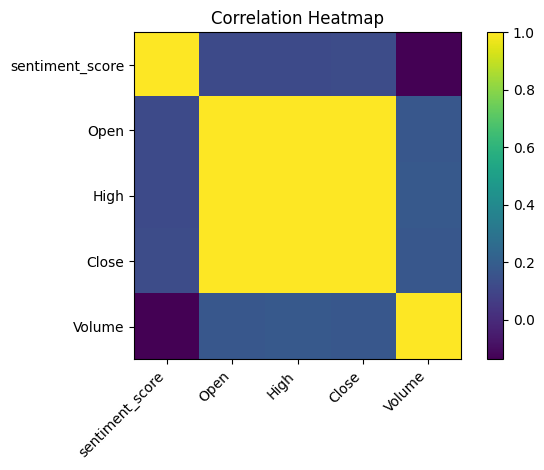

In [49]:
# Select numeric columns for correlation
numeric_cols = ['sentiment_score', 'Open', 'High', 'Close', 'Volume']
corr_matrix = data_merged[numeric_cols].corr()

print("Correlation Matrix:\n", corr_matrix)


plt.figure()
plt.imshow(corr_matrix, cmap='viridis', interpolation='nearest')
plt.title('Correlation Heatmap')
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.tight_layout()
plt.show()


***Causality Testing***

In [52]:
# Compute daily returns from Close price if not already done
data_merged['Returns'] = data_merged['Close'].pct_change()
data_merged.dropna(subset=['Returns', 'sentiment_score'], inplace=True)

data = data_merged[['Returns', 'sentiment_score']].dropna()
max_lags = 5

results = grangercausalitytests(data[['Returns', 'sentiment_score']], maxlag=max_lags, verbose=False)

for lag in results.keys():
    # The first element of results[lag] is a dictionary with the test results
    test_results_dict = results[lag][0]
    print(f"\nLag {lag}:")
    for test_type, test_result in test_results_dict.items():
        # test_result is a tuple of (test_statistic, p_value, degrees_of_freedom, ...)
        # The structure varies slightly by test type
        print(f"  {test_type}:")
        print(f"    Test Statistic: {test_result[0]}")
        print(f"    p-value: {test_result[1]}")
        # Depending on the test, you may have 2 or 4 elements in test_result
        # Typically:
        # ssr_ftest, params_ftest: (F_statistic, p_value, df_denom, df_num)
        # ssr_chi2test, lrtest: (chi2_statistic or lr_statistic, p_value, df)

        # If it's an F-type test:
        if test_type in ['ssr_ftest', 'params_ftest']:
            print(f"    df_denom: {test_result[2]}")
            print(f"    df_num: {test_result[3]}")
        else:
            # lrtest and ssr_chi2test return 3 values: stat, p_value, df
            print(f"    df: {test_result[2]}")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Lag 1:
  ssr_ftest:
    Test Statistic: 154.39650655236315
    p-value: 2.8141856909629806e-35
    df_denom: 15204.0
    df_num: 1
  ssr_chi2test:
    Test Statistic: 154.4269715299781
    p-value: 1.8681834837740317e-35
    df: 1
  lrtest:
    Test Statistic: 153.64813742315164
    p-value: 2.764555540418929e-35
    df: 1
  params_ftest:
    Test Statistic: 154.3965065523312
    p-value: 2.8141856910064515e-35
    df_denom: 15204.0
    df_num: 1.0

Lag 2:
  ssr_ftest:
    Test Statistic: 79.67417645143317
    p-value: 3.784858728070676e-35
    df_denom: 15201.0
    df_num: 2
  ssr_chi2test:
    Test Statistic: 159.40076667594144
    p-value: 2.4353607970244453e-35
    df: 2
  lrtest:
    Test Statistic: 158.57108034312841
    p-value: 3.687460770966517e-35
    df: 2
  params_ftest:
    Test Statistic: 79.67417645142766
    p-value: 3.784858728093427e-35
    df_denom: 15201.0
    df_num: 2.0

Lag 3:
  ssr_ftest:
    Test Statistic: 54.145143512973
    p-value: 8.363714552388884e-35
  

***Volatility Summary Statistics***

Volatility Summary Statistics:
 count    15188.000000
mean         0.004066
std          0.004711
min          0.000000
25%          0.001522
50%          0.002841
75%          0.005060
max          0.051497
Name: Volatility, dtype: float64

Count of Days by Volatility Level:
 Volatility_Level
Medium    7591
High      3800
Low       3797
Name: count, dtype: int64


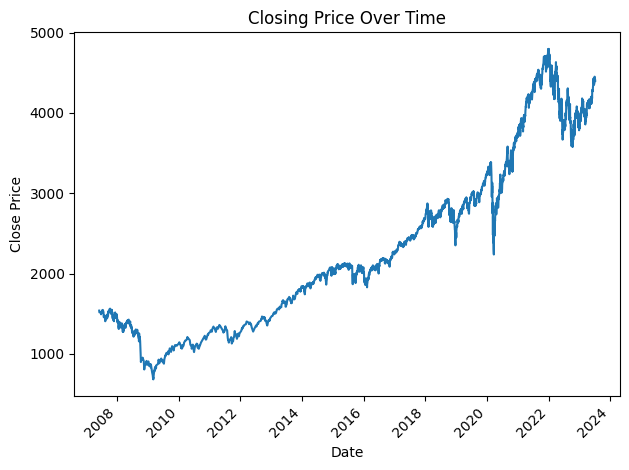

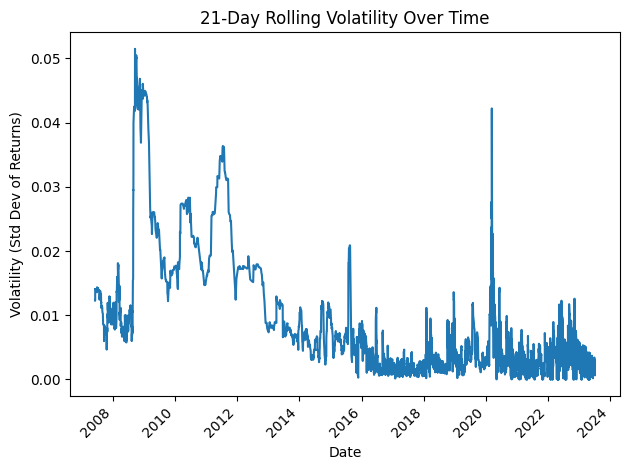

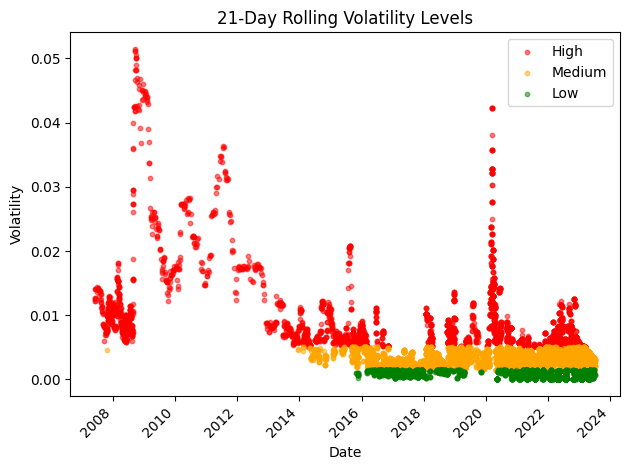

In [53]:
# Ensure Returns column is computed (if not already)
if 'Returns' not in data_merged.columns:
    data_merged['Returns'] = data_merged['Close'].pct_change()

# Compute a rolling volatility measure (21-day rolling standard deviation of returns)
window_size = 21  # This can be adjusted
data_merged['Volatility'] = data_merged['Returns'].rolling(window=window_size).std()

# Drop any rows where Volatility could not be computed due to insufficient data at the start
data_merged.dropna(subset=['Volatility'], inplace=True)

# Summary statistics of Volatility
print("Volatility Summary Statistics:\n", data_merged['Volatility'].describe())

# Identify volatile vs. stable periods
# For example, define volatile as the top 25% of volatility values and stable as the bottom 25%
q75 = data_merged['Volatility'].quantile(0.75)
q25 = data_merged['Volatility'].quantile(0.25)

data_merged['Volatility_Level'] = np.where(data_merged['Volatility'] >= q75, 'High',
                                 np.where(data_merged['Volatility'] <= q25, 'Low', 'Medium'))

# Print how many days fall into each category
print("\nCount of Days by Volatility Level:\n", data_merged['Volatility_Level'].value_counts())

# Plot closing prices over time
plt.figure()
plt.plot(data_merged['Date'], data_merged['Close'])
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot volatility over time
plt.figure()
plt.plot(data_merged['Date'], data_merged['Volatility'])
plt.title(f'{window_size}-Day Rolling Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility (Std Dev of Returns)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Highlighting volatile vs stable periods could be done by marking them on the plot.
# For simplicity, we'll create separate plots or use color-coded markers.
plt.figure()
for level, color in zip(['High', 'Medium', 'Low'], ['red', 'orange', 'green']):
    subset = data_merged[data_merged['Volatility_Level'] == level]
    plt.scatter(subset['Date'], subset['Volatility'], label=level, alpha=0.5, s=10, c=color)

plt.title(f'{window_size}-Day Rolling Volatility Levels')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# This gives a visual and tabular idea of which periods were more volatile (High) and which were stable (Low).
# You can further inspect these periods by filtering df_merged based on Volatility_Level and then checking the news (Title, Content) for context.


***Analysis of top Volatility days***

In [54]:
# Identify the top volatile and stable periods
# We'll focus on "High" (most volatile) and "Low" (most stable) periods
high_vol = data_merged[data_merged['Volatility_Level'] == 'High']
low_vol = data_merged[data_merged['Volatility_Level'] == 'Low']

# Sort these by Volatility descending to find the highest volatility days
high_vol = high_vol.sort_values(by='Volatility', ascending=False)
low_vol = low_vol.sort_values(by='Volatility', ascending=True)

print("Top 10 Highest Volatility Days:")
display(high_vol[['Date', 'Close', 'Volatility', 'Title', 'Content']].head(10))

print("\nTop 10 Lowest Volatility Days:")
display(low_vol[['Date', 'Close', 'Volatility', 'Title', 'Content']].head(10))

# Count word occurrences in the 'Title' or 'Content' during high volatility days
# to get a sense of common themes. (Simple textual analysis)
# Convert all text to lowercase and split by whitespace

# Combine all titles/content from high volatility days
all_high_titles = " ".join(high_vol['Title'].astype(str)).lower()
all_high_content = " ".join(high_vol['Content'].astype(str)).lower()

# Simple tokenization: remove non-alphabetic characters and split
tokens_titles = re.findall(r'\b[a-z]+\b', all_high_titles)
tokens_content = re.findall(r'\b[a-z]+\b', all_high_content)

title_word_freq = Counter(tokens_titles)
content_word_freq = Counter(tokens_content)

# Display the top 10 most common words in Titles and Content during high volatility
print("\nTop 10 most common words in Titles during high volatility periods:")
for word, freq in title_word_freq.most_common(10):
    print(f"{word}: {freq}")

print("\nTop 10 most common words in Content during high volatility periods:")
for word, freq in content_word_freq.most_common(10):
    print(f"{word}: {freq}")


Top 10 Highest Volatility Days:


,Date,Close,Volatility,Title,Content
14731,2008-09-16,1213.59,0.051497,Fed Keeps Rate at 2%,Fed Keeps Rate at 2%United States Interest Rat...
14730,2008-09-17,1156.39,0.051181,Bank Fears Hit Stocks,Bank Fears Hit StocksUnited States Stock Marke...
14732,2008-09-16,1213.59,0.051121,U.S. Stocks Drop for a Second Day,U.S. Stocks Drop for a Second DayUnited States...
14725,2008-10-01,1161.06,0.050495,U.S. Senate Approves $700 Billion Financial-Re...,U.S. Senate Approves $700 Billion Financial-Re...
14723,2008-10-03,1099.22,0.050119,"U.S. Payrolls Fell by 159,000","U.S. Payrolls Fell by 159,000United States Une..."
14722,2008-10-03,1099.22,0.050116,House passes $700 billion financial bailout,House passes $700 billion financial bailoutUni...
14724,2008-10-02,1114.28,0.050078,Will the Rescue Plan Help the U.S. Economy?,Will the Rescue Plan Help the U.S. Economy?Uni...
14726,2008-09-26,1213.27,0.048930,U.S. Economic Growth Slower,U.S. Economic Growth SlowerUnited States GDP G...
14728,2008-09-22,1207.08,0.048250,What’s Next for the United States?,What’s Next for the United States?United State...
14727,2008-09-22,1207.08,0.048250,Dollar Weakens Most Since Euro's 1999 Debut,Dollar Weakens Most Since Euro's 1999 DebutUni...



Top 10 Lowest Volatility Days:


,Date,Close,Volatility,Title,Content
2426,2022-08-04,4151.93,0.0,Vulcan Materials earnings below expectations a...,Vulcan Materials earnings below expectations a...
2629,2022-07-28,4072.42,0.0,T. Rowe Price earnings below expectations at 1...,T. Rowe Price earnings below expectations at 1...
2630,2022-07-28,4072.42,0.0,Baxter International earnings meet market expe...,Baxter International earnings meet market expe...
2631,2022-07-28,4072.42,0.0,Mastercard earnings above expectations at 2.56...,Mastercard earnings above expectations at 2.56...
2632,2022-07-28,4072.42,0.0,Reliance Steel & Aluminum earnings above expec...,Reliance Steel & Aluminum earnings above expec...
2633,2022-07-28,4072.42,0.0,Teleflex earnings above expectations at 3.39 USD,Teleflex earnings above expectations at 3.39 U...
2634,2022-07-28,4072.42,0.0,Masco earnings below expectations at 1.14 USD,Masco earnings below expectations at 1.14 USDU...
2635,2022-07-28,4072.42,0.0,Carlyle earnings above expectations at 1.17 USD,Carlyle earnings above expectations at 1.17 US...
2636,2022-07-28,4072.42,0.0,Kimco Realty earnings below expectations at -0...,Kimco Realty earnings below expectations at -0...
2637,2022-07-28,4072.42,0.0,Textron earnings below expectations at 0.81 USD,Textron earnings below expectations at 0.81 US...



Top 10 most common words in Titles during high volatility periods:
us: 1870
in: 913
at: 663
stocks: 512
to: 462
earnings: 445
s: 437
usd: 429
dollar: 423
expectations: 403

Top 10 most common words in Content during high volatility periods:
the: 14978
in: 8496
to: 6732
of: 6316
and: 5535
a: 4794
states: 4403
on: 3434
us: 3389
percent: 3005


In [56]:
import nltk
# This downloads the necessary list of stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [57]:

# Ensure that nltk's stopwords are downloaded
# nltk.download('stopwords') # Uncomment if needed

stop_words = set(stopwords.words('english'))

# Combine all titles/content from high volatility days
all_high_titles = " ".join(high_vol['Title'].astype(str)).lower()
all_high_content = " ".join(high_vol['Content'].astype(str)).lower()

# Simple tokenization: remove non-alphabetic characters and split
tokens_titles = re.findall(r'\b[a-z]+\b', all_high_titles)
tokens_content = re.findall(r'\b[a-z]+\b', all_high_content)

# Filter out stopwords
filtered_titles = [word for word in tokens_titles if word not in stop_words]
filtered_content = [word for word in tokens_content if word not in stop_words]

title_word_freq = Counter(filtered_titles)
content_word_freq = Counter(filtered_content)

print("\nTop 10 most common words in Titles during high volatility periods (stopwords removed):")
for word, freq in title_word_freq.most_common(10):
    print(f"{word}: {freq}")

print("\nTop 10 most common words in Content during high volatility periods (stopwords removed):")
for word, freq in content_word_freq.most_common(10):
    print(f"{word}: {freq}")



Top 10 most common words in Titles during high volatility periods (stopwords removed):
us: 1870
stocks: 512
earnings: 445
usd: 429
dollar: 423
expectations: 403
u: 388
rise: 276
high: 255
week: 252

Top 10 most common words in Content during high volatility periods (stopwords removed):
states: 4403
us: 3389
percent: 3005
expectations: 1512
week: 1435
usd: 1408
market: 1405
year: 1380
month: 1370
rate: 1174


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<Figure size 640x480 with 0 Axes>

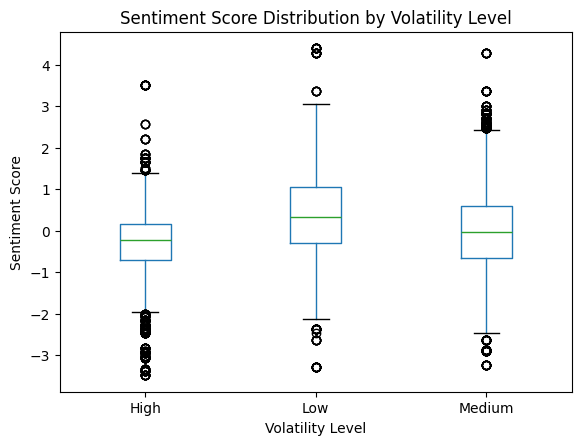

In [58]:
# Ensure nltk stopwords and potentially punkt are downloaded
nltk.download('punkt')

# 1. Compare Sentiment Distributions Across Volatility Levels
plt.figure()
data_merged.boxplot(column='sentiment_score', by='Volatility_Level', grid=False)
plt.title('Sentiment Score Distribution by Volatility Level')
plt.suptitle('')  # Remove default subtitle
plt.xlabel('Volatility Level')
plt.ylabel('Sentiment Score')
plt.show()

# This gives a quick visual clue if sentiment differs in distribution across volatility regimes.

Periods of high market volatility are associated with sentiment scores that cluster closer together, with fewer extreme deviations, possibly reflecting more uniformly uncertain or cautious sentiment. Surprisingly, low volatility periods, which might be expected to correspond to calmer sentiment, actually exhibit a wider range and more extreme outliers. This suggests that when markets are stable, the narrative could diversify, producing a broader spectrum of sentiment. Medium volatility sits in between, as expected, showing a moderate range and fewer extremes than the low volatility group